<h1>Advanced lane detection steps:</h1>

* Obtain correction matrix for lense distortion

* Convert images to HLS format and extract S channel data

* Get bird eye view of lanes

* Apply sobel filters to get edge detection

* Apply thresholds in differential output - i.e. threshold against magnitude and direction

* Use histogram data to detect left and right lanes and draw 2nd order polynomial line

* Find centrepoint of polynomial line

* Augment data with line data

In [1]:
#STEP 1: Obtain correction matrix for lense detection, 
# Code taken from https://github.com/udacity/CarND-Advanced-Lane-Lines/examples
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

from IPython.display import Image
from IPython.display import display
import math
import glob
import pickle

%matplotlib inline

def corner_details():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    gray = ''
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump(dist_pickle, open( "camera_calibration_result.p", "wb" ))        

def cal_undistort(img, mtx, dist):
    # Use cv2.calibrateCamera and cv2.undistort()
    undist = cv2.undistort(img, mtx, dist, None, mtx)    
    return undist

In [2]:
corner_details()
with open("camera_calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

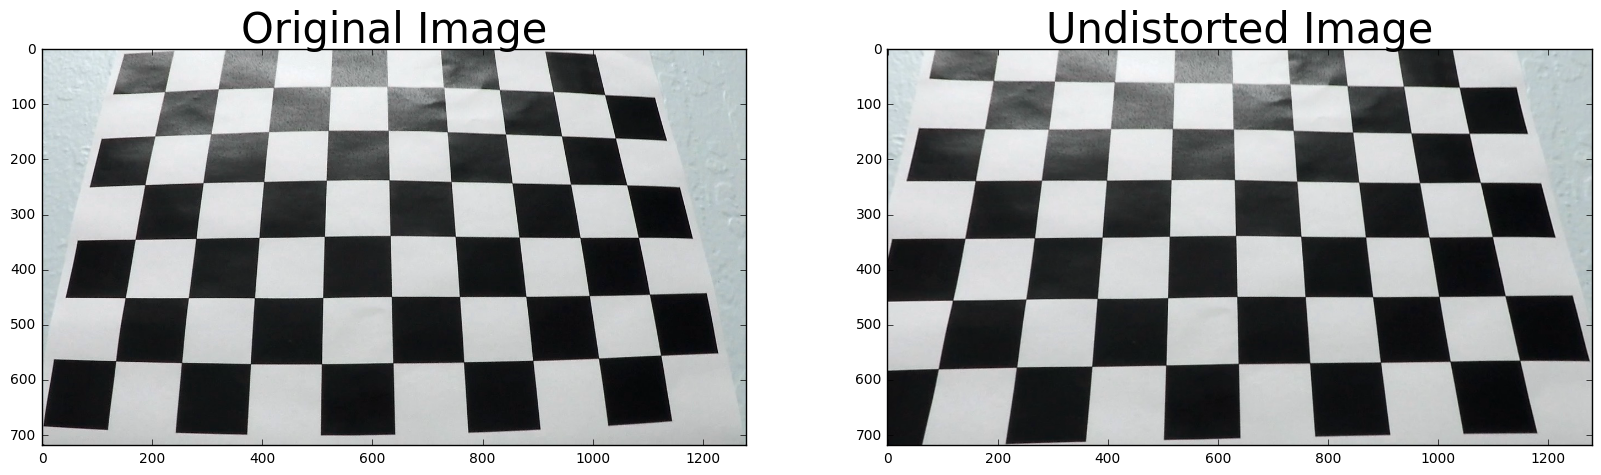

In [39]:
#Undistort test image
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration3.jpg')

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

dst = cal_undistort(img, mtx, dist)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)


In [71]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp_birds_eye_view(img, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cal_undistort(img, mtx, dist)
    # Convert undistorted image to grayscale
    gray = img
    if len(np.asarray(img))==2:
        gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    
    img_size = gray.shape

    src = np.float32(
    [[120, 720],
     [550, 470],
     [700, 470],
     [1160, 720]])

    dst = np.float32(
    [[200,720],
     [200,0],
     [1080,0],
     [1080,720]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, (img_size[1], img_size[0]), flags=cv2.INTER_LINEAR)
    # Return the resulting image
    return warped

In [27]:
#Image filters
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    #Convert to grayscale if given gray scale image
    gray = img
    if len(img.shape) ==3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #plt.imshow(gray)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
       
    abs_sobel = np.absolute(abs_sobel)
    abs_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    binary_output = np.zeros_like(abs_sobel)
    # Inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(abs_sobel >= thresh[0]) & (abs_sobel <=thresh[1])] = 1
    
    #plt.imshow(scaled_sobel, cmap ='gray')
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/4)):
    # Grayscale
    #Convert to grayscale if given gray scale image
    gray = img
    if len(img.shape) ==3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    #plt.imshow(binary_output, cmap ='gray')
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(10, 255)): 
    # Convert to grayscale
    #Convert to grayscale if given gray scale image
    gray = img
    if len(img.shape) ==3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    gradmag = np.uint8(gradmag*255/np.max(gradmag))
    
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    #Rescale to 8 bit
    scale_factor = np.max(binary_output)/255
    gradmag = (binary_output/scale_factor).astype(np.uint8) 
    #plt.imshow(gradmag, cmap ='gray')
    return gradmag

def combined_filters(image, ksize = 3):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=5, thresh=(50, 200))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=5, thresh=(50, 200))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(20,150))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(.6,1.1))
    combined = np.zeros_like(dir_binary)
    #Find absolute value
    combined[((gradx != 0) & (grady != 0)) | ((mag_binary != 0) & (dir_binary != 0))] = 1
    return combined

def gaussian_blur(img, kernel=5):
    # Apply Gaussian Blur
    blur = cv2.GaussianBlur(img,(kernel,kernel),0)
    return blur

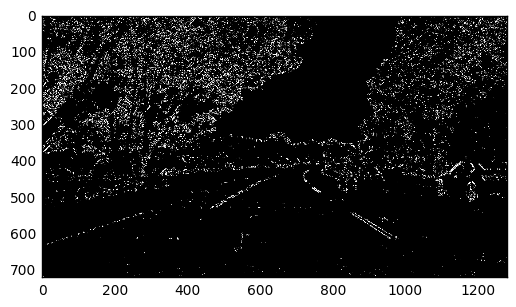

In [40]:
#Test Sobel filters and color filters
test_img = cv2.imread('test_images/test5.jpg')
img2 =  combined_filters(test_img)
plt.imshow(img2, cmap ='gray')
#plt.imshow(test_img)

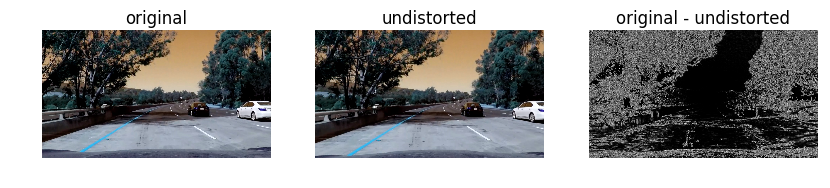

In [41]:
#Undistort and view image
image = cv2.imread('test_images/test5.jpg')
image_ud = cal_undistort(image, mtx, dist)
plt.figure(figsize=(10,2))
plt.subplot(1,3,1)
plt.imshow(image)
plt.axis('off');
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(image_ud)
plt.title('undistorted')
plt.axis('off');
plt.subplot(1,3,3)
plt.imshow(np.sum((image-image_ud)**2,axis=2),cmap='gray')
plt.title('original - undistorted')
plt.axis('off');

(-0.5, 1279.5, 719.5, -0.5)

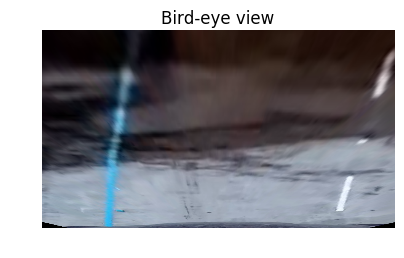

In [53]:
#Undistort and view image
image = cv2.imread('test_images/test5.jpg')
image_ud = cal_undistort(image, mtx, dist)
birds_eye_view = corners_unwarp_birds_eye_view(image, mtx, dist)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(birds_eye_view)
plt.title('original')
plt.axis('off')
plt.title('Bird-eye view')
plt.axis('off')

In [31]:
#Color mask filters
def color_mask(hsv,low,high):
    # Return mask from HSV 
    mask = cv2.inRange(hsv, low, high)
    return mask

def apply_color_mask(hsv,img,low,high):
    # Apply color mask to image
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img,img, mask= mask)
    return res

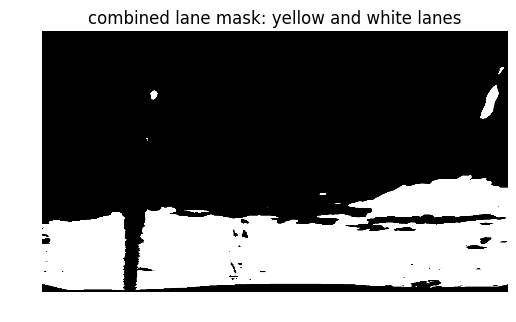

In [113]:
#get birdes eye image
birds_eye_view = corners_unwarp_birds_eye_view(image, mtx, dist)

#Apply color filters
image_hsv=  image_HSV = cv2.cvtColor(birds_eye_view,cv2.COLOR_RGB2HSV)
image_hsv = gaussian_blur(image_hsv, kernel=5)
#White filters
white_hsv_low  = np.array([ 0,   0,   160])
white_hsv_high = np.array([ 255,  80, 255])

#Yellow filters
yellow_hsv_low  = np.array([ 0,  100,  100])
yellow_hsv_high = np.array([ 80, 255, 255])
#Combined color masks
mask_yellow = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
mask_white = color_mask(image_HSV,white_hsv_low,white_hsv_high)
mask_lane = cv2.bitwise_or(mask_yellow,mask_white)
plt.imshow(mask_lane,cmap='gray')
plt.title('combined lane mask: yellow and white lanes')
plt.axis('off');

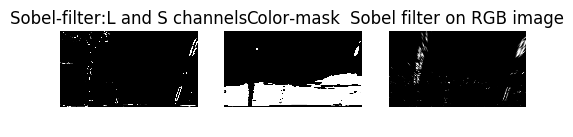

In [118]:
#Apply sobel filters on L and S channels
image_HLS = cv2.cvtColor(birds_eye_view,cv2.COLOR_RGB2HLS)
#Sobel on L
img_l = image_HLS[:,:,1]
img_abs_x = abs_sobel_thresh(img_l,'x',5,(50,225))
img_abs_y = abs_sobel_thresh(img_l,'y',5,(50,225))
sobel_l = cv2.bitwise_or(img_abs_x,img_abs_y)
#Sobel on S
img_l = image_HLS[:,:,2]
img_abs_x = abs_sobel_thresh(img_l,'x',5,(50,225))
img_abs_y = abs_sobel_thresh(img_l,'y',5,(50,225))
sobel_s = cv2.bitwise_or(img_abs_x,img_abs_y)
#Combined L and S channels
image_cmb = cv2.bitwise_or(sobel_s,sobel_l)

#plt.imshow(image)
image = cv2.imread('test_images/test5.jpg')
sob_c = combined_filters(image)
#Apply image undistortion and perspective transform
bird = corners_unwarp_birds_eye_view(sob_c, mtx, dist)
#Gaussian blur
g_bird = gaussian_blur(bird, kernel=5)
#Combine with color filters
#Convert Sobel filter output to binary
#g_bird = g_bird.astype(int)

#combined_filters =  np.copy(cv2.bitwise_or(g_bird, mask_lane))
plt.subplot(1,3,1)
plt.imshow(image_cmb,cmap='gray')
plt.axis('off')
plt.title('Sobel-filter:L and S channels')
plt.subplot(1,3,2)
plt.imshow(mask_lane,cmap='gray')
plt.axis('off')
plt.title('Color-mask')
plt.subplot(1,3,3)
plt.imshow(g_bird,cmap='gray')
plt.axis('off')
plt.title('Sobel filter on RGB image')

/home/kiarie/anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/kiarie/anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/kiarie/anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/kiarie/anaconda/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(0, 1280)

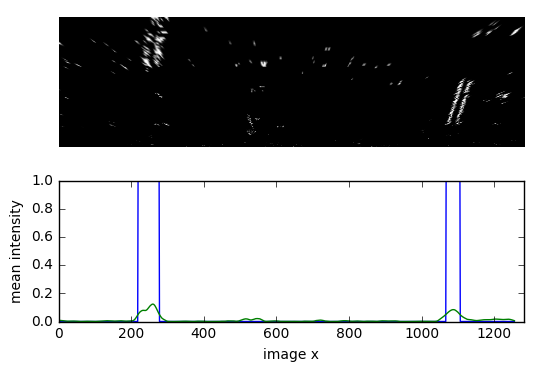

In [109]:
#image_cmb1 = gaussian_blur(image_cmb1,5) 
def moving_average(a, n=3):
    # Moving average
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
img_size = bird.shape
mov_filtsize = img_size[1]/50.
mean_lane = np.mean(bird[img_size[0]/2:,:],axis=0)
mean_lane = moving_average(mean_lane,mov_filtsize)


plt.subplot(2,1,1)
plt.imshow(bird[img_size[0]/2:,:],cmap='gray')
plt.axis('off')
plt.subplot(2,1,2)
plt.plot(mean_lane>.05)
plt.plot(mean_lane)
plt.xlabel('image x')
plt.ylabel('mean intensity')
plt.xlim(0,img_size[1])

In [93]:
#Color threshold in HLS channel
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [3]:
def process_image(image):
    #pipeline
    #greyscale image
    gray = grayscale(img)
    
    #apply color filter for white and yellow lines
    img = color_filter(image)
    
    #histogram equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(gray)

    #apply Gaussian blur
    gaus_gray = gaussian_blur(cl1, 7)

    #apply sobel edge detectors
    
    
    #apply image segmentation
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(490, 300), (490, 300), (imshape[1]-60,imshape[0])]], dtype=np.int32)
    reg_gray = region_of_interest(can_gray, vertices = vertices)
    
    #Apply histogram polyfit finder
    
    #apply image augmentation
    lane_extrap = pic_overlay(reg_gray, rho=2, theta=np.pi/180, threshold=1, min_line_len=10, max_line_gap=1)

    #apply line extrapolation on hough_coord
    draw_lanes = weighted_img(img =lane_extrap, initial_img=image, α=0.8, β=1., λ=0.)
    return draw_lanes

In [ ]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)